# Import statements


In [1]:
import os

import pandas as pd 

from pymatgen.core.structure import Molecule
from pymatgen.io.lammps.outputs import parse_lammps_log

from mdproptools.utilities.fluctuations import plot_fluctuations
from mdproptools.structural.cluster_analysis import (
    get_clusters,
    get_unique_configurations,
)

# System overview 

The system we will use for cluster analysis contains 0.5 M Mg(TFSI)2 in DME. In this notebook, we will be calculating the radial distribution function (RDF) and the coordination number of the Mg2+ ion with other atom types in the system. In addition, we will be extracting the first solvation shell around the cation and processing these clusters to obtain the top unique configurations that make up around 80% of the Mg2+ solvation environment in this system. 


# Initialization


In [2]:
dump_files = os.path.join("../data/structural/Mg_2TFSI_G1.lammpstrj.*")
npt_log_file = os.path.join("../data/utilities/log.mixture_npt")
# Create pymatgen Molecule objects for each molecule in the system and 
#place them in a list in the same order they appear in the LAMMPS dump file 
dme = Molecule.from_file("../data/structural/dme.pdb")
tfsi = Molecule.from_file("../data/structural/tfsi.pdb")
mg = Molecule.from_file("../data/structural/mg.pdb") 
molecules = [dme, tfsi, mg]

# Define the names of the molecules in the system and the atom types that 
# will be used to identify the coordination environment of the Mg2+ ion when 
# extracting the first solvation shell 
mol_names = ["dme", "tfsi", "mg"]
type_coord_atoms = ["O", "N", "Mg"]

# Since the dump files do not contain the element property, we need to specify
# the elements in the system in the order they appear in the LAMMPS dump file 
# so that the correct atom types can be assigned to each atom when extracting 
# the first solvation shell 
elements = ["O", "C", "H", "N", "S", "O", "F", "Mg"]

# Specify the atom type of the atom of interest (Mg2+ ion) and the cutoff radius 
# to be used when extracting the first solvation shell 
atom_type = 8
r_cut = 2.3
max_force = 0.75

# Specify the number of molecules in the system and the number of atoms per 
# molecule in the same order they appear in the LAMMPS dump file 
num_mols = [591, 66, 33]
num_atoms_per_mol = [16, 15, 1]

# Specify whether the full trajectory should be used for cluster analysis 
# or just a single frame 
full_trajectory = True
frame = None # If full_trajectory is False, specify the frame number to be used for cluster analysis 

# We will be using the default atom types assigned by LAMMPS for this system, 
# so we will not be altering the atom types, atom_type 8 corresponds to the Mg2+ ion 
alter_atom_types = False

# All files will be saved in working_dir, which defaults to the current 
# working directory if not specified 
working_dir = None

# System Fluctuations
Here, we will use the log file from the NPT run to plot the fluctuations of various properties of interest of the system. This is an important step to ensure that the system has equilibrated and none of the properties like temperature or pressure are fluctuating wildly before proceeding with further analysis.

Temp: mean = 298.26350457771116, std = 2.3898353746855308
Press: mean = 23.923132172938526, std = 498.7782735224649
TotEng: mean = 8746.83945884058, std = 229.05839085677493
PotEng: mean = -568.8030158895552, std = 217.01674941922033
KinEng: mean = 9315.642474412793, std = 74.64155405931086
Volume: mean = 120926.0888005997, std = 1049.4612224223251
Density: mean = 0.9963576316141929, std = 0.008344234540688819
Lx: mean = 49.45039650974513, std = 0.1412711046678761
E_bond: mean = 3099.851521726637, std = 81.37883313768121
E_angle: mean = 4561.767224267866, std = 107.36337885790986
E_dihed: mean = 871.3578215342328, std = 29.611421170115744
E_pair: mean = -9101.779583508245, std = 101.28803026039334
E_vdwl: mean = -3065.204084357821, std = 58.13480825536161
E_coul: mean = 9734.770956871564, std = 73.88032679145668
E_long: mean = -15771.346453773114, std = 7.1473205304496705
Fnorm: mean = 3313.5169027586203, std = 76.46424131679831


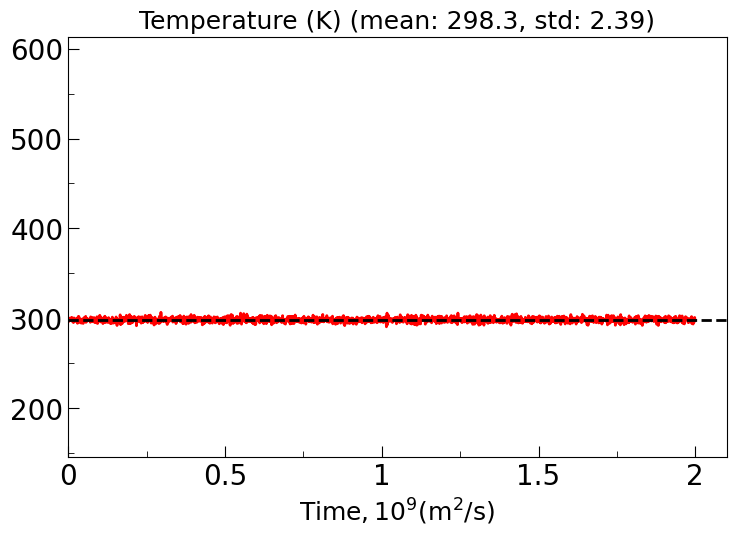

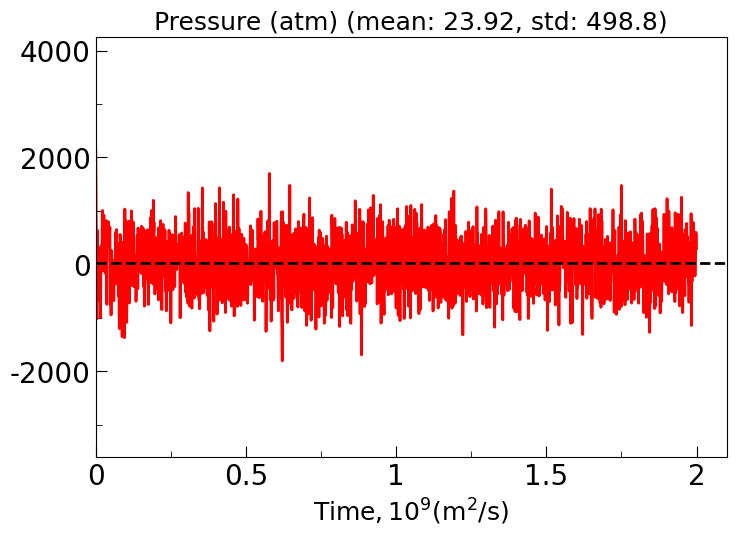

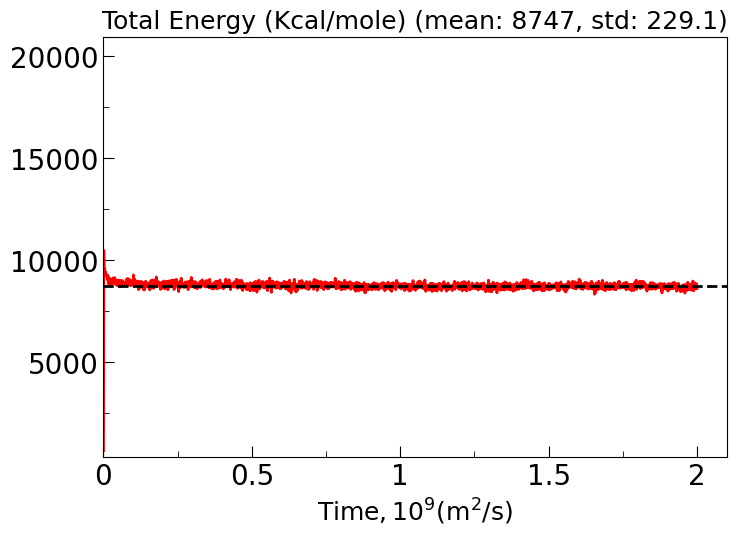

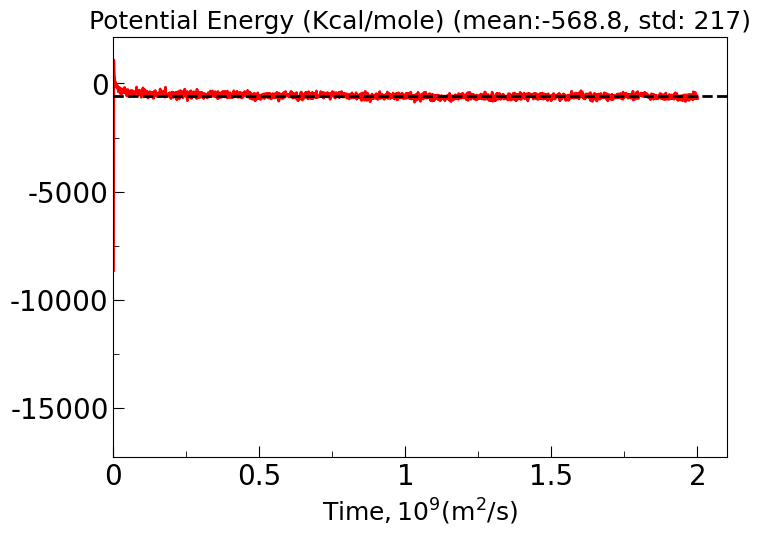

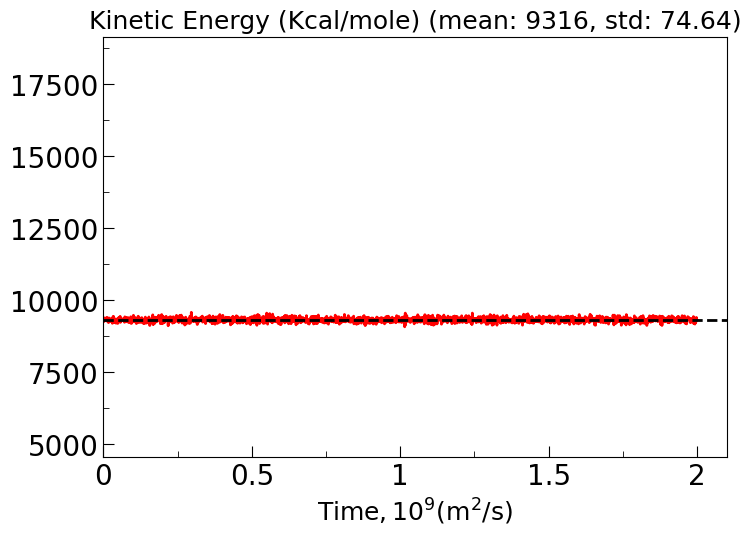

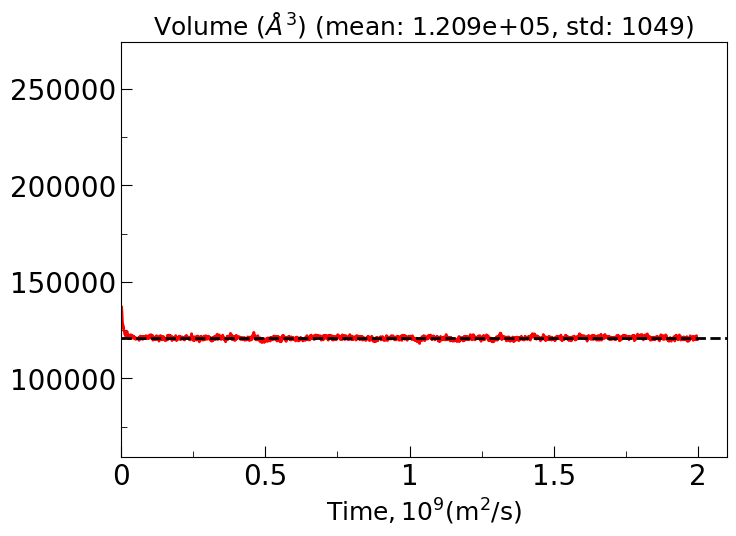

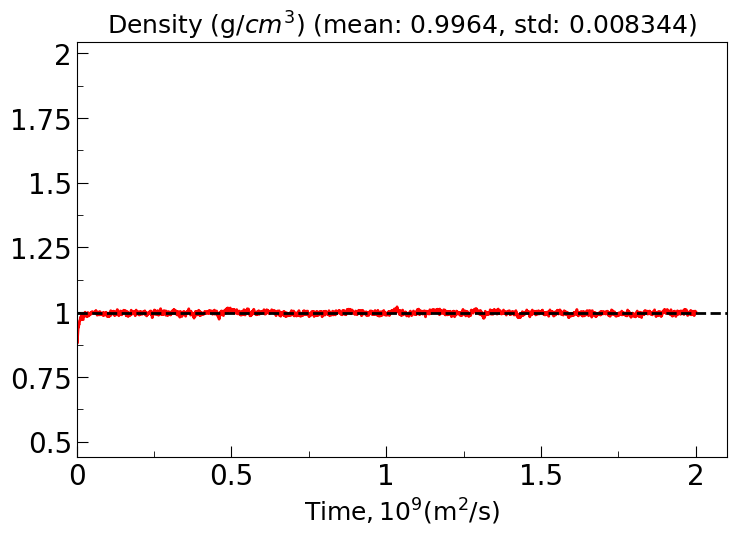

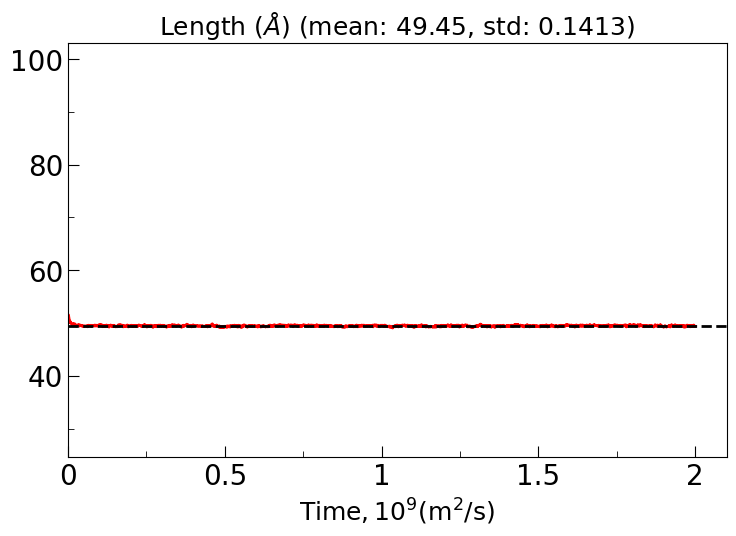

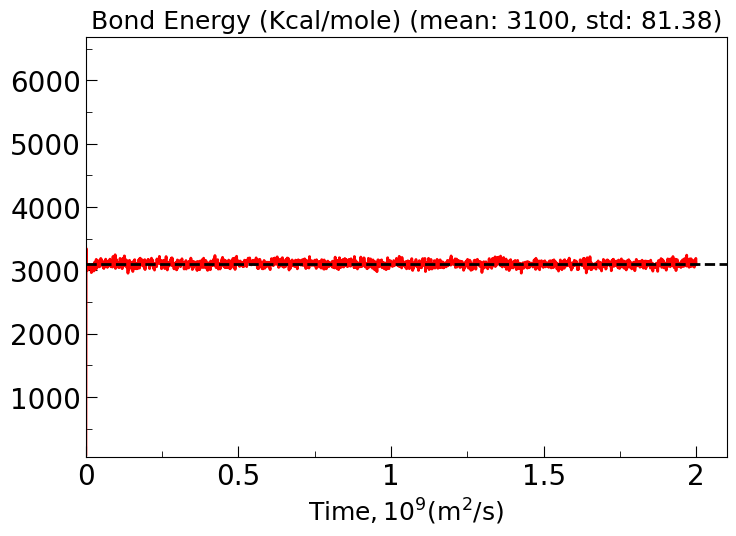

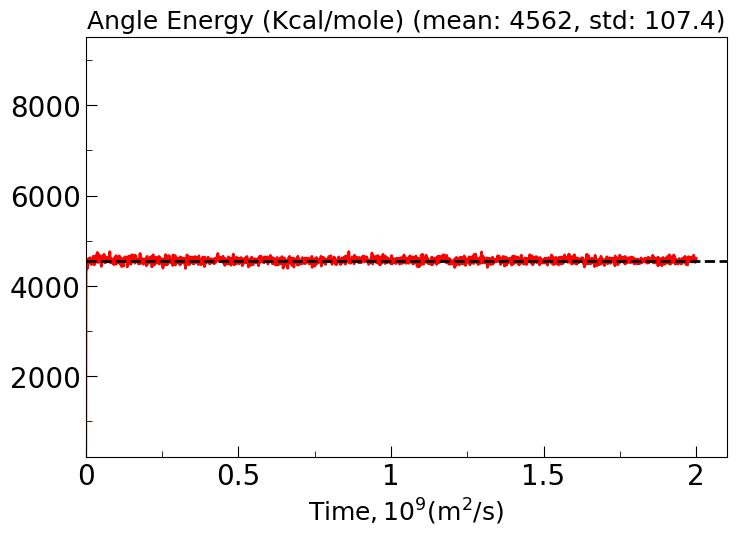

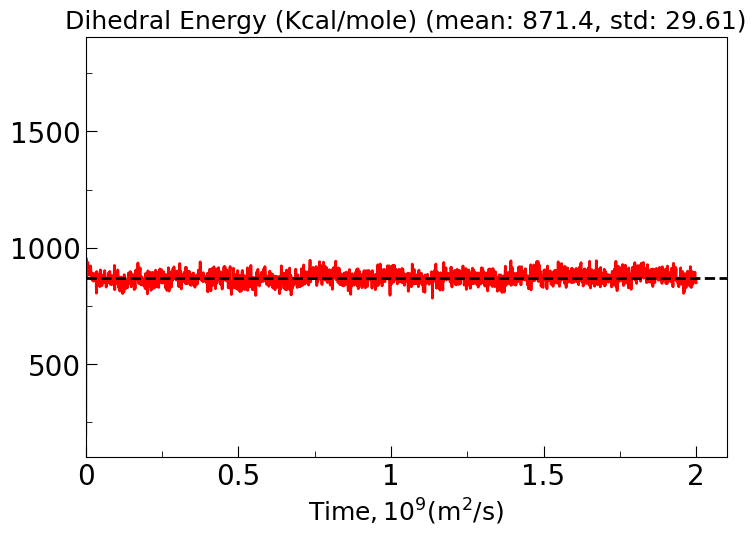

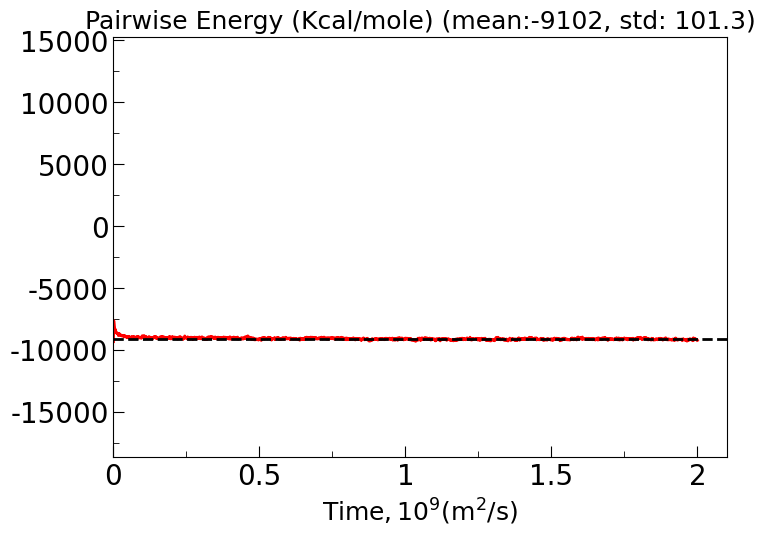

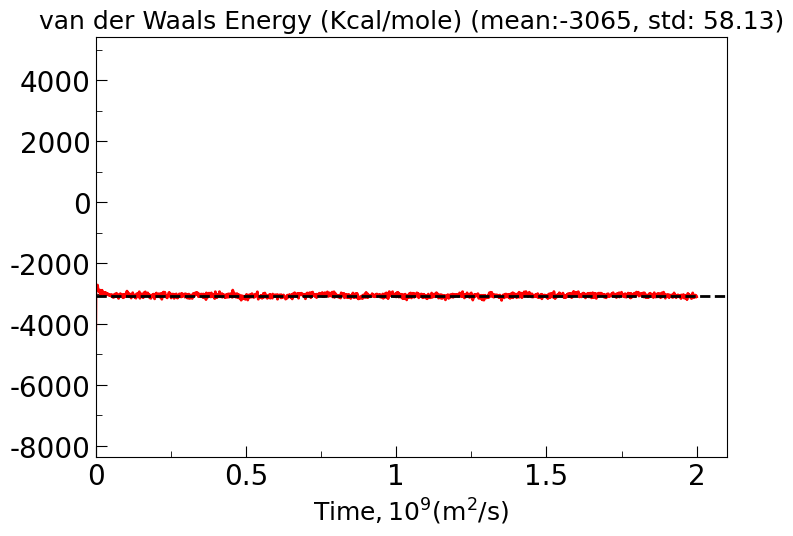

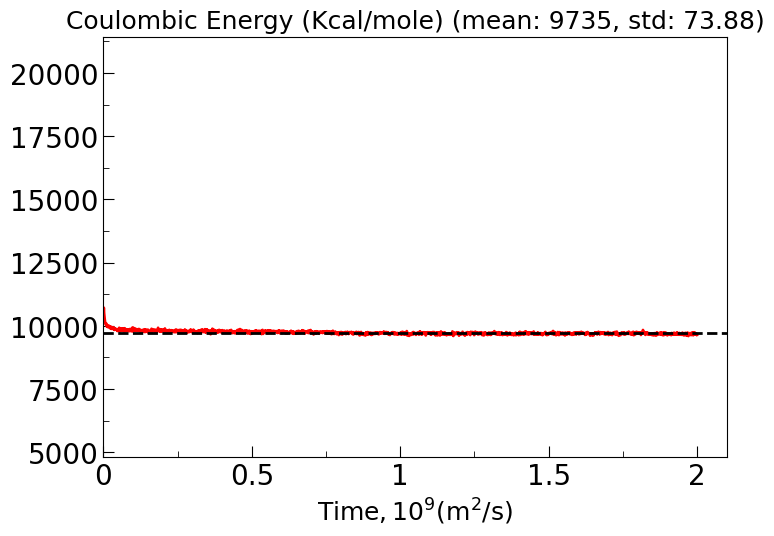

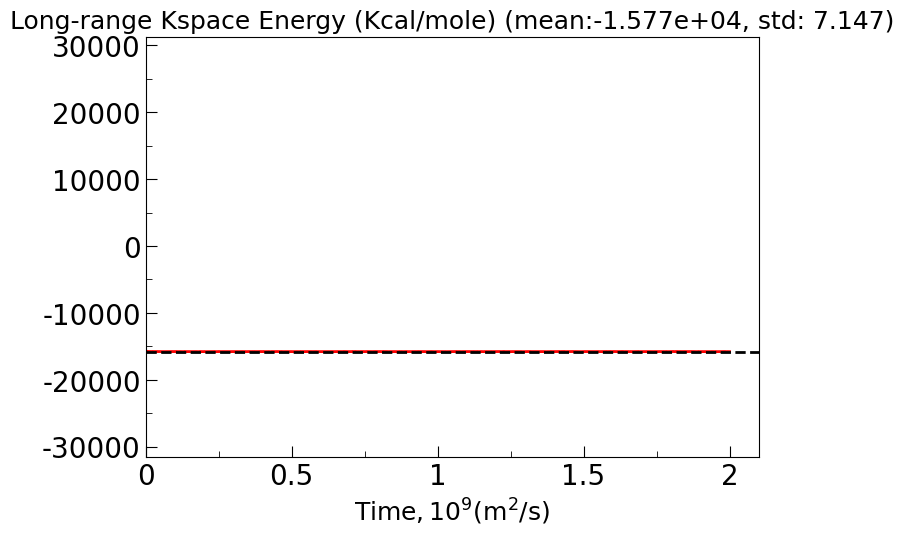

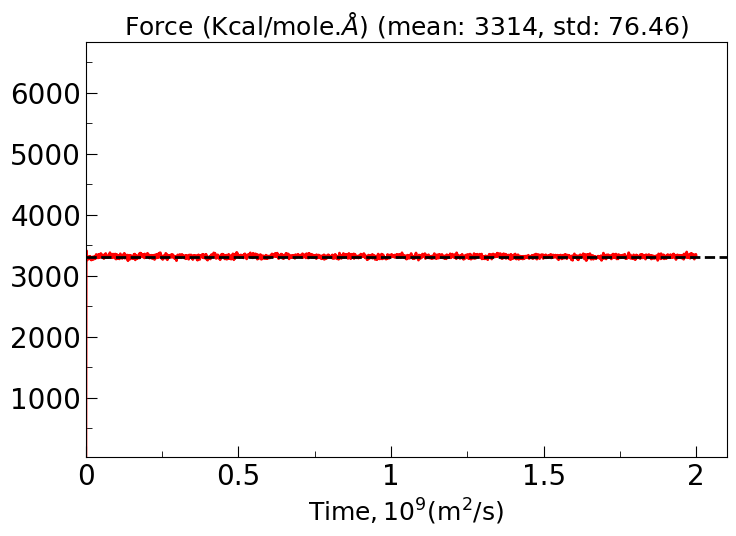

In [3]:
npt_log = parse_lammps_log(npt_log_file)
props = {
    "Temp": ["Temperature (K)", "temperature_fluctuations"],
    "Press": ["Pressure (atm)", "pressure_fluctuations"],
    "TotEng": ["Total Energy (Kcal/mole)", "total_energy_fluctuations"],
    "PotEng": ["Potential Energy (Kcal/mole)", "potential_energy_fluctuations"],
    "KinEng": ["Kinetic Energy (Kcal/mole)", "kinetic_energy_fluctuations"],
    "Volume": ["Volume ($\AA^3$)", "volume_fluctuations"],
    "Density": ["Density (g/$cm^3$)", "density_fluctuations"],
    "Lx": ["Length ($\AA$)", "length_fluctuations"],
    "E_bond": ["Bond Energy (Kcal/mole)", "bond_energy_fluctuations"],
    "E_angle": ["Angle Energy (Kcal/mole)", "angle_energy_fluctuations"],
    "E_dihed": ["Dihedral Energy (Kcal/mole)", "dihedral_energy_fluctuations"],
    "E_pair": ["Pairwise Energy (Kcal/mole)", "pairwise_energy_fluctuations"],
    "E_vdwl": ["van der Waals Energy (Kcal/mole)", "vdwl_energy_fluctuations"],
    "E_coul": ["Coulombic Energy (Kcal/mole)", "coulombic_energy_fluctuations"],
    "E_long": [
        "Long-range Kspace Energy (Kcal/mole)",
        "longrange_energy_fluctuations",
    ],
    "Fnorm": ["Force (Kcal/mole.$\AA$)", "force_fluctuations"],
}

for prop, (title, filename) in props.items():
    prop_mean, prop_std = plot_fluctuations(npt_log[0], prop, title, filename)

# RDF analysis


# Coordination number analysis


# Coordination number analysis


## Get clusters


In [4]:
num_clusters = get_clusters(
    filename=dump_files,
    atom_type=atom_type,
    r_cut=r_cut,
    num_mols=num_mols,
    num_atoms_per_mol=num_atoms_per_mol,
    full_trajectory=full_trajectory,
    frame=frame,
    elements=elements,
    alter_atom_types=alter_atom_types,
    max_force=max_force,
    working_dir=working_dir,
)

Processing dump files: 100%|██████████| 5/5 [00:05<00:00,  1.12s/it]


## Get unique configurations

In [5]:
clusters_df, conf_df = get_unique_configurations(
    cluster_pattern="Cluster_*.xyz",
    r_cut=r_cut,
    molecules=molecules,
    type_coord_atoms=type_coord_atoms,
    working_dir=working_dir,
    find_top=True,
    perc=None,
    cum_perc=80,
    mol_names=mol_names,
    zip=True,
)

Processing cluster files: 100%|██████████| 165/165 [00:01<00:00, 133.24it/s]


In [6]:
top_conf_df = pd.read_csv("top_conf.csv")
top_conf_df

,num_dme,num_tfsi,num_mg,atoms_dme,atoms_tfsi,atoms_mg,count,%,cluster
0,1,2,0,2O,2O:2O,NaN,58,35.151515,Cluster_0_20.xyz
1,2,1,0,2O:2O,2O,NaN,40,24.242424,Cluster_4_10.xyz
2,3,0,0,2O:2O:2O,NaN,NaN,30,18.181818,Cluster_3_09.xyz


The above results indicate that around 35% of the Mg2+ solvation environment is made up of the 1 DME molecule contributing 2 oxygen atoms and 2 TFSI anions contributing two oxygen atoms each. The second most frequent solvation shell consists of 2 DME molecules contributing 2 ether oxygens each and 1 TFSI anion contributing two oxygen atoms. Finally, the third most frequent solvation shell consists of 3 DME molecules contributing 2 ether oxygens each in bidentate configuration. To visualize these clusters, you can open the conf_*.xyz files in this directory in a visualization software such as VMD or Avogadro.  